# Read & stack seismic data

In [1]:
# import useful packages
import obspy
import numpy as np
from obspy import UTCDateTime
import pandas as pd
import os
import math
import matplotlib.pyplot as plt

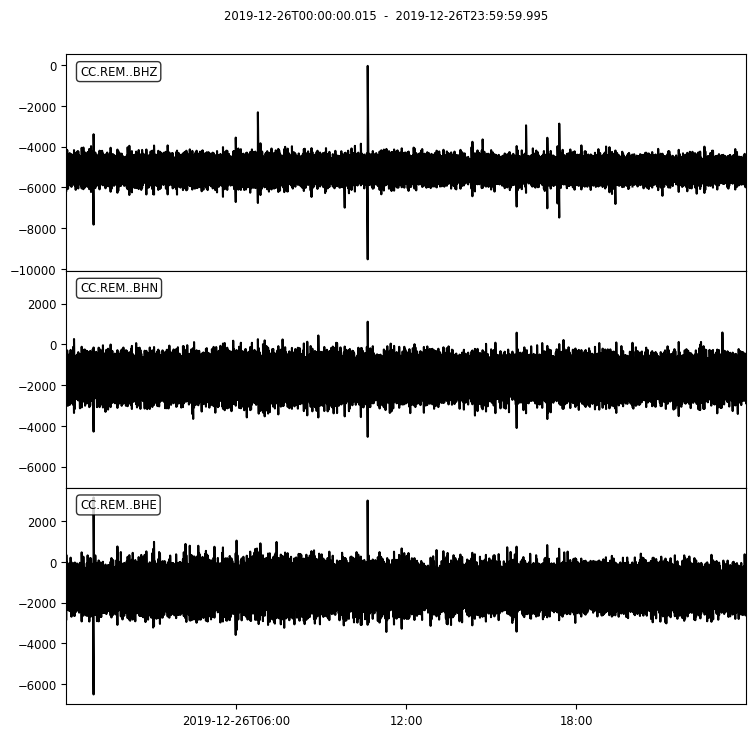

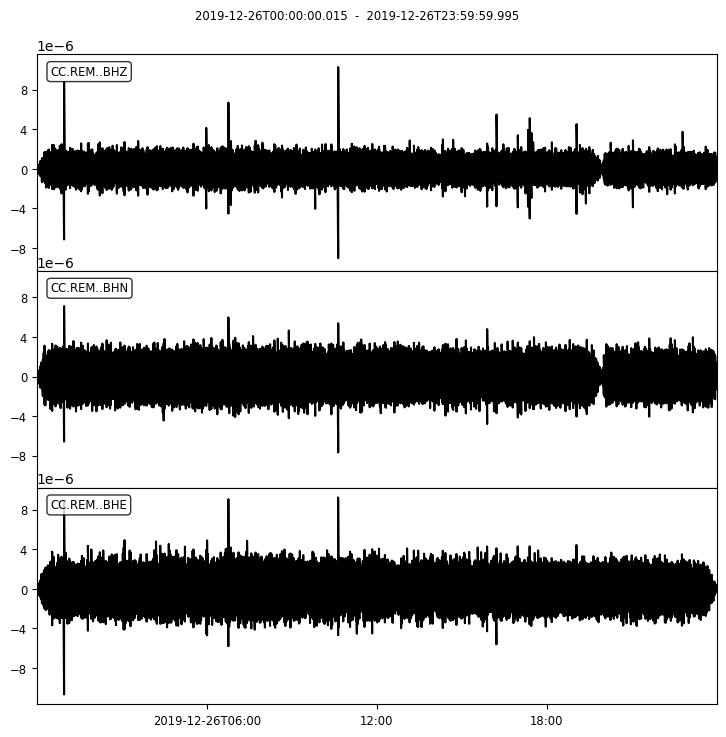

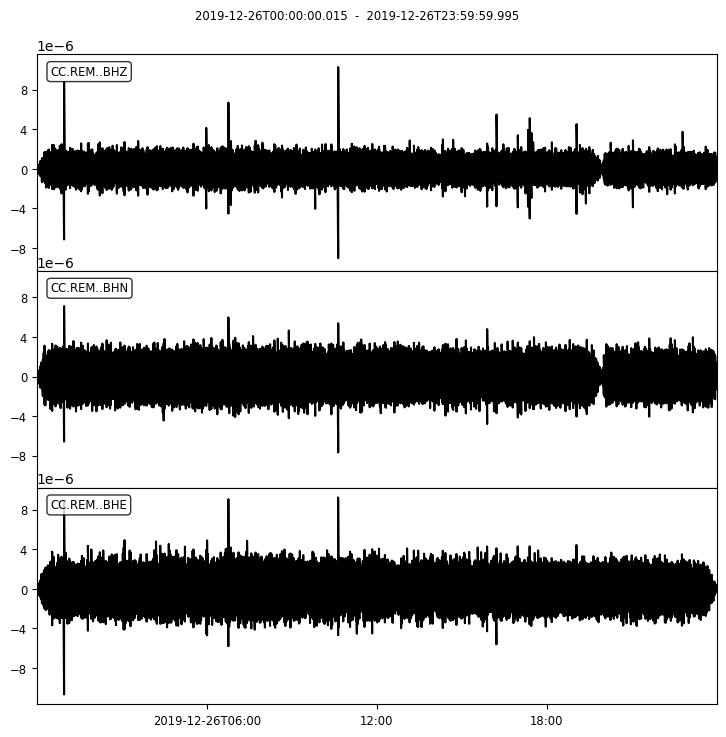

In [6]:
year = 2019
jday = 360
net = 'CC'
sta = 'REM'
cha = '*'


import sys
sys.path.append("/data/wsd01/pnwstore/")
from pnwstore.mseed import WaveformClient
client = WaveformClient()

st_read = client.get_waveforms(network=net, station=sta, channel=cha,
                                               year='{}'.format(year), doy='{}'.format(jday))
# correct insrument response
inv = obspy.read_inventory('/auto/pnwstore1-wd11/PNWStationXML/{}/{}.{}.xml'.format(net,net,sta))
pre_filt = [1e-3, 5e-2, 45, 50]
water_level = 60
st_corr = st_read.copy()
for tr in st_corr:
    tr.remove_response(inventory=inv, zero_mean=True,taper=True, taper_fraction=0.05,
                          pre_filt=pre_filt, output="VEL", water_level=water_level,
                          plot=False)

st_read.plot()
st_corr.plot()

In [ ]:
st_read

In [2]:
# stations as string 'network-station-channel'
s1  = 'UW-EDM-EHZ'
s2  = 'UW-SHW-EHZ'
s3  = 'UW-HSR-EHZ'
s4  = 'UW-SOS-EHZ'
s5  = 'UW-JUN-EHZ'
s6  = 'UW-ELK-EHZ'
s7  = 'UW-TDL-EHZ'
s8  = 'UW-SUG-EHZ'
s9  = 'UW-YEL-EHZ'
s10 = 'UW-FL2-EHZ'
s11 = 'UW-CDF-EHZ' #-?H?

s12 = 'UW-SEP-EHZ' #-?H?
s13 = 'CC-SEP-EHZ' #-?H?
# s14 = 'UW-STD-EHZ'
s15 = 'CC-STD-BHZ'

s16 = 'CC-VALT-BHZ' #-BH?
s17 = 'CC-JRO-BHZ'
s18 = 'CC-HOA-BHZ' #-BH?
s19 = 'CC-LOO-BHZ' #-BH?
s20 = 'CC-USFR-BHZ' #-BH?
s21 = 'CC-NED-EHZ'
s22 = 'CC-REM-BHZ' #-BH?
s23 = 'CC-SWFL-BHZ' #-BH?
s24 = 'CC-SFW2-BHZ' #-BH?
s25 = 'CC-MIDE-EHZ'
s26 = 'CC-MIBL-EHZ'
s27 = 'CC-BLIS-EHZ'
s28 = 'CC-RAFT-EHZ'
s29 = 'CC-SPN5-EHZ'
s30 = 'CC-SEND-EHZ'

# list_stations = [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,
#                  s12,s13,s15,
#                  s16,s17,s18,s19,s20,s21,s22,s23,s24,s25,s26,s27,s28,s29,s30] # make a list of all stations
# list_stations = [s1,s2,s3,s4,s5,s6,s7,s10,s11] # make a list of all stations
list_stations = [s2]

In [3]:
# define UTC date and time of data to read and stack
year = 2004
jday = 276 # 1.10 --> 275 expl     2.10 --> 276 tremor     3.10 --> 277 tremor
hour = 18 # stat plot 18 UTC       stat plot 18 UTC        stat plot 8 UTC
dt = 4 # hours

import sys
sys.path.append("/data/wsd01/pnwstore/")
from pnwstore.mseed import WaveformClient
client = WaveformClient()

st = obspy.Stream() # empty streama

for netstacha in list_stations:
    try:
        net = netstacha.split('-')[0]
        sta = netstacha.split('-')[1]
        cha = netstacha.split('-')[2]
        st_read = client.get_waveforms(network=net, station=sta, channel=cha,
                                               year='{}'.format(year), doy='{}'.format(jday)) # read data to stream

        if len(st_read)>0: # to check if stream is empty
            # correct insrument response
            inv = obspy.read_inventory('/auto/pnwstore1-wd11/PNWStationXML/{}/{}.{}.xml'.format(net,net,sta))
            pre_filt = [1e-3, 5e-2, 45, 50]
            water_level = 60
            st_corr = st_read.copy()
            for tr in st_corr:
                tr.remove_response(inventory=inv, zero_mean=True,taper=True, taper_fraction=0.05,
                                      pre_filt=pre_filt, output="VEL", water_level=water_level,
                                      plot=False)
                
            st_trim = st_corr.trim(UTCDateTime(year=year,julday=jday,hour=hour),UTCDateTime(year=year,julday=jday,hour=hour+dt))        
            st_trim.merge() 
            st += st_trim
        
        else:
            print('Empty stream for {}.'.format(netstacha))
                    
    except:
        print('Could not read data for {}.'.format(netstacha))

print('***done***')
st

***done***


1 Trace(s) in Stream:
UW.SHW..EHZ | 2004-10-02T17:59:59.999400Z - 2004-10-02T21:59:59.999400Z | 100.0 Hz, 1440001 samples (masked)

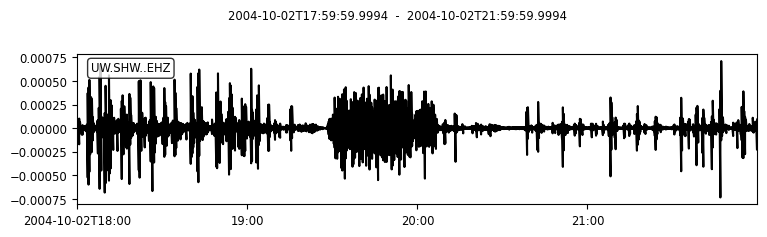

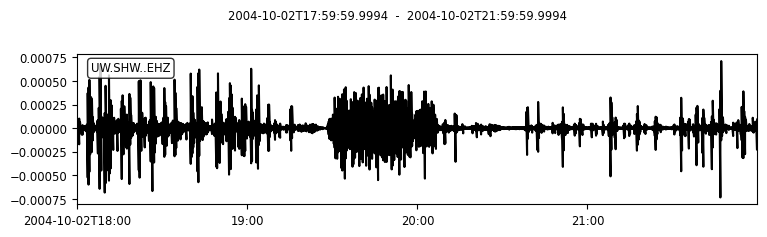

In [4]:
st.plot()

In [5]:
# stack the traces in stream
st_stack = st.copy()
st_stack.stack(time_tol=1) # time_tol gives tolerance of starttimes in seconds

1 Trace(s) in Stream:
UW.SHW..EHZ | 2004-10-02T17:59:59.999400Z - 2004-10-02T21:59:59.999400Z | 100.0 Hz, 1440001 samples

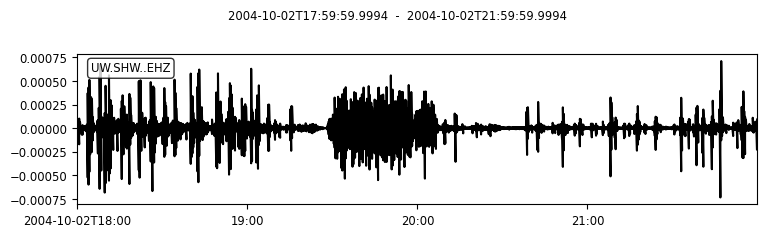

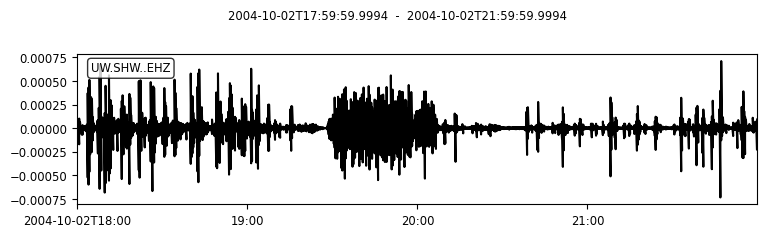

In [6]:
st_stack.plot()

In [16]:
stack_sta_list = []
for tr in st:
    stack_sta_list.append(tr.stats.station)
stack_sta_string = '_'.join(stack_sta_list)
stack_sta_string

'SHW'

In [17]:
# save stack as mseed
st_stack.write("stack_tremor{}_{}.mseed".format(jday,stack_sta_string), format="MSEED") 

/home/koepflma/anaconda3/envs/seismo/lib/python3.8/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


# TEST

In [2]:
st = obspy.read("/Users/koepflma/Desktop/GIT/skience2023/01_Monday/Morning/ObsPy/data/example.mseed")
st_copy = obspy.Stream(traces=[st[0],st[2],st[4]])
st_copy = st_copy.trim(UTCDateTime('2014-04-04T01:34'),UTCDateTime(' 2014-04-04T02:15'))
st_copy = st_copy.detrend('linear')
st_copy

3 Trace(s) in Stream:
IV.BDI..BHE | 2014-04-04T01:33:59.995000Z - 2014-04-04T02:14:59.995000Z | 20.0 Hz, 49201 samples
IV.BDI..BHN | 2014-04-04T01:33:59.975000Z - 2014-04-04T02:14:59.975000Z | 20.0 Hz, 49201 samples
IV.BDI..BHZ | 2014-04-04T01:33:59.995000Z - 2014-04-04T02:14:59.995000Z | 20.0 Hz, 49201 samples

In [3]:
st_copy2 = st_copy.copy()
st_copy2.stack(time_tol=1) # time_tol gives tolerance of starttimes in seconds 
# save stack as mseed
st_copy2.write("test_stack.mseed", format="MSEED") 
st_copy2

1 Trace(s) in Stream:
IV.BDI.. | 2014-04-04T01:33:59.995000Z - 2014-04-04T02:14:59.995000Z | 20.0 Hz, 49201 samples

1 Trace(s) in Stream:
IV.BDI.. | 2014-04-04T01:33:59.995000Z - 2014-04-04T02:14:59.995000Z | 20.0 Hz, 49201 samples


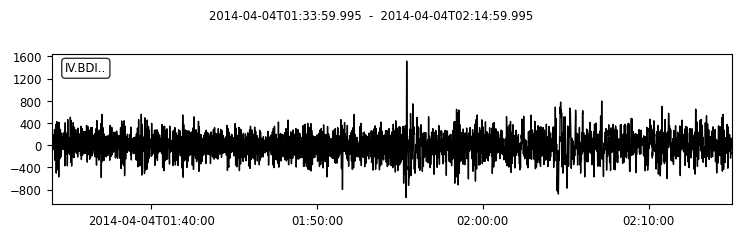

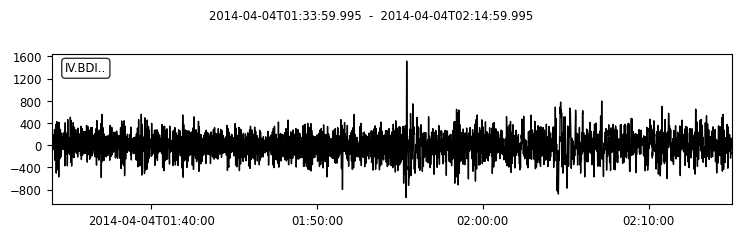

In [5]:
st_stack = obspy.read("/Users/koepflma/Desktop/GIT/Mt-St-Helens/noise_analysis/test_stack.mseed")
print(st_stack)
st_stack.plot()

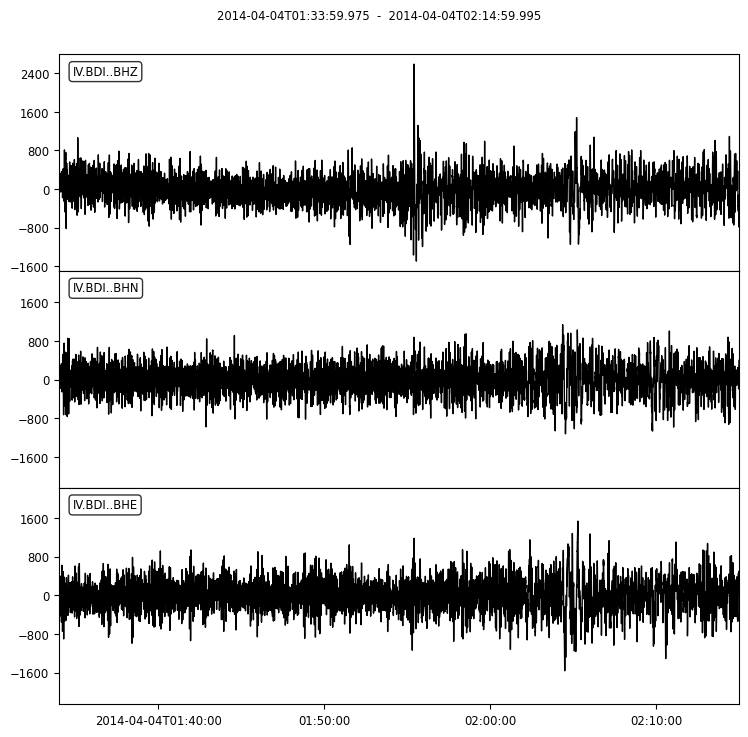

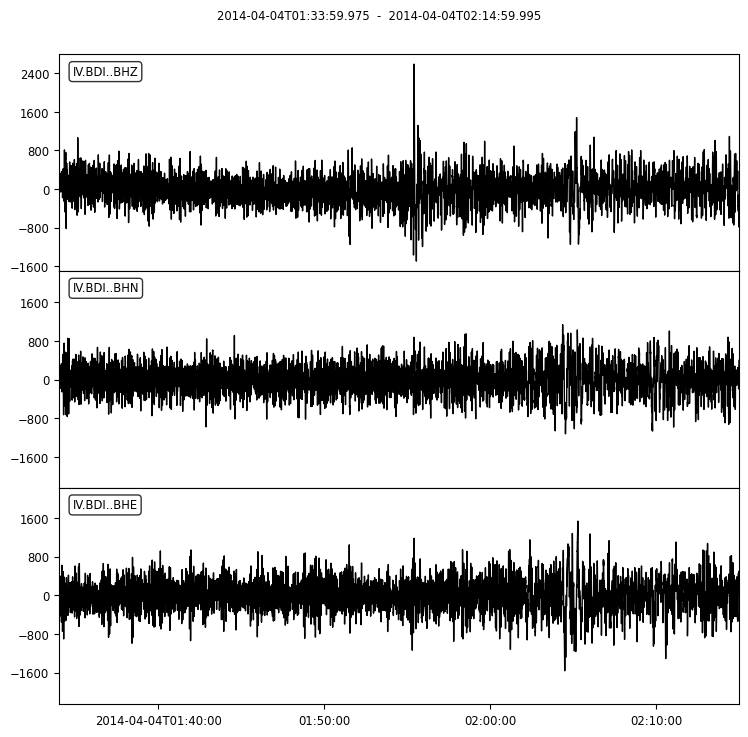

In [122]:
st_copy.plot()

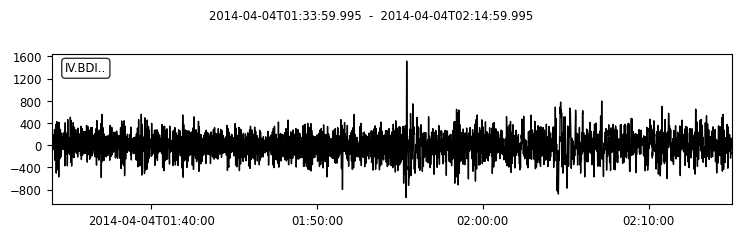

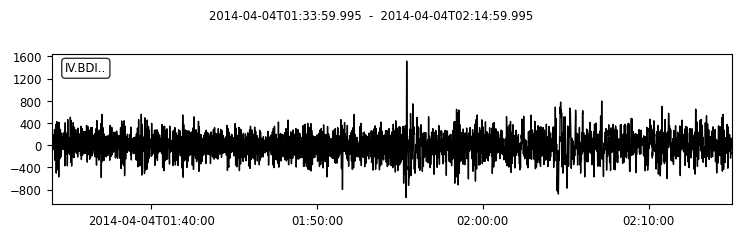

In [123]:
st_copy2.plot()

In [124]:
for i,tr in enumerate(st_copy):
    if i == 0:
        stack = tr.data
    if i != 0:
        stack += tr.data
stack = stack/len(st_copy)

In [125]:
tr_stack = obspy.Trace(data=stack)
tr_stack.stats.starttime = st_copy[0].stats.starttime
tr_stack.stats.sampling_rate = st_copy[0].stats.sampling_rate
st_stack = obspy.Stream(tr_stack)
st_stack
# st_stack.write("stack_{}.mseed", format="MSEED")

1 Trace(s) in Stream:
... | 2014-04-04T01:33:59.995000Z - 2014-04-04T02:14:59.995000Z | 20.0 Hz, 49201 samples

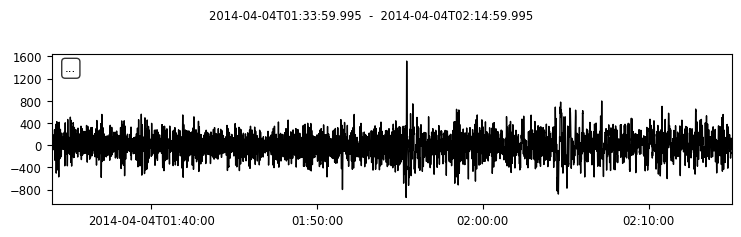

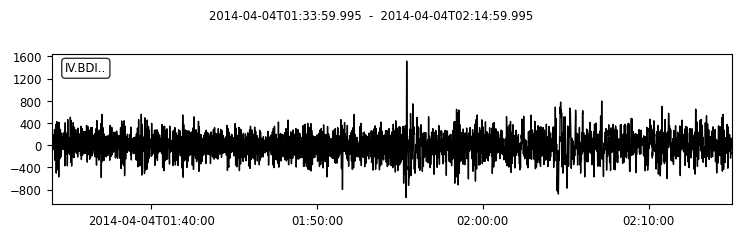

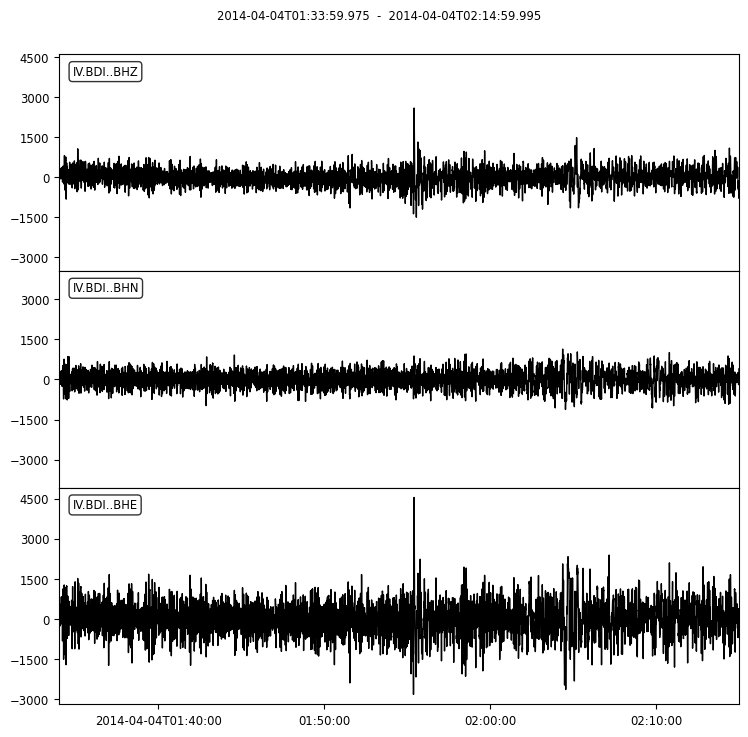

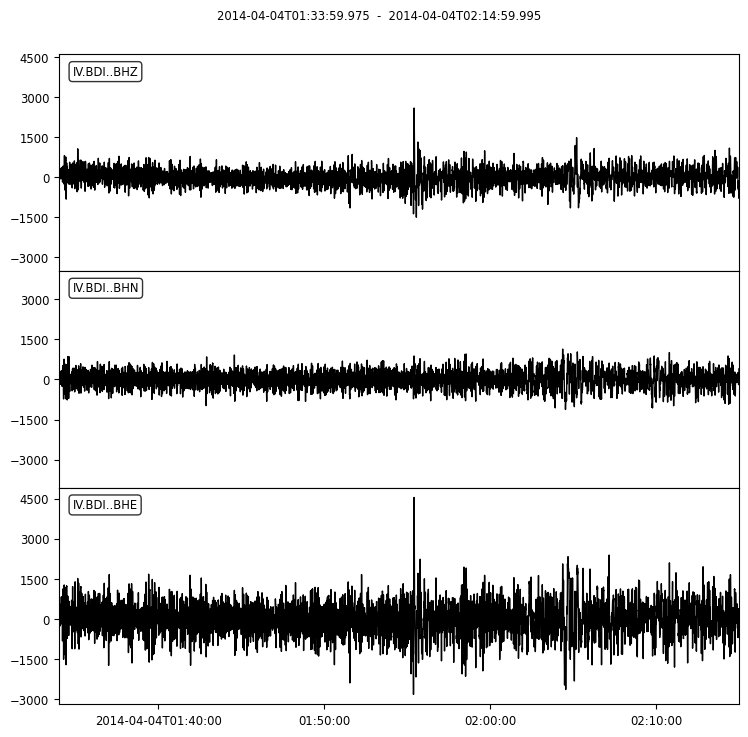

In [126]:
st_stack.plot()
st_copy2.plot()
st_copy.plot()

In [83]:
st_copy

3 Trace(s) in Stream:
IV.BDI..BHE | 2014-04-04T01:33:59.995000Z - 2014-04-04T02:14:59.995000Z | 20.0 Hz, 49201 samples
IV.BDI..BHN | 2014-04-04T01:33:59.975000Z - 2014-04-04T02:14:59.975000Z | 20.0 Hz, 49201 samples
IV.BDI..BHZ | 2014-04-04T01:33:59.995000Z - 2014-04-04T02:14:59.995000Z | 20.0 Hz, 49201 samples

In [ ]:
# stack the traces in stream
stack = np.zeros_like(st[0].data) # initialize array with zeros of same shape of first trace
for tr in st:
    tr.data

In [ ]:
# save stack as mseed
# tr_stack = obspy.Trace(data=np.arange(0, 10))
# tr_stack.stats.starttime = st[0].stats.starttime
# st_stack = obspy.Stream(tr_stack)
st_stack.write("stack_{}.mseed", format="MSEED") 

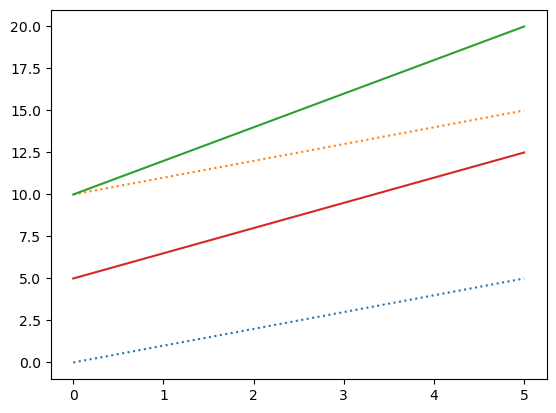

In [20]:
data1 = np.arange(6)
data2 = np.arange(10,16)
plt.plot(data1,':')
plt.plot(data2,':')
plt.plot(data1+data2)
plt.plot(data1+data2/2)